# Detecting COVID-19 with Chest X Ray using PyTorch

Image classification of Chest X Rays in one of three classes: Normal, Viral Pneumonia, COVID-19




costum Dataset from [COVID-19 Radiography Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) on Kaggle

# Importing Libraries

In [1]:
%matplotlib inline

import os
import shutil
import random
import torch 
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.7.1


# Preparing Training and Test Sets

In [2]:
class_names = ['normal', 'viral', 'covid']
root_dir = 'COVID-19 Radiography Database'
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))
    
    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c))]  #if x.lower().endswith('png') ]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

# Creating Custom Dataset

In [3]:
class ChestXRayDataset(torch.utils.data.Dataset):
    
    def __init__(self, image_dirs, transform):#transform will pass here for data augmentation
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name])] #if x[-3:].lower().endswith("png" or "JPEG" or "JPG")]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names) #randomly select the class
        index = index % len(self.images[class_name]) #if we have 3000 pics our index will be any where between 0 to 2999 just to avoid any out of bands index value
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB') # these are mostley black and white images so we are going to convert to RGB
        # if we wanted  to create a cnn out of scratches we wouldnt have to do this because we could simply use a channel value of 1
        #but we are going to use resnet 18 and pre trained weights of resnet 18
        #the input is already defined and we have three channels so we need to use RGB
        return self.transform(image), self.class_names.index(class_name)

# Image Transformations

In [4]:
#what are we going to do is create two transform objects which will be applied to train set and test set
#here we should obey a bunch of rules for example the size of image which our model expects

train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),#this is for data augmentation the idea is if the normal pic says normal class the horizontal flip say also this
    torchvision.transforms.ToTensor(),#then convert the image to tensor to be use in computation
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])#finall normalize the data, it should normalize in a specific range which this resnet 18 model was trained on 
])
#we can set a mean and standard deviation for different channels which are different access that we have in the tensor. the values are defined


#apart from data augumentation everything else is the same

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Prepare DataLoader

In [5]:
train_dirs = {
    'normal': 'COVID-19 Radiography Database/train/normal',
    'viral': 'COVID-19 Radiography Database/train/viral',
    'covid': 'COVID-19 Radiography Database/train/covid'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 1423 normal examples
Found 1315 viral examples
Found 1225 covid examples


In [6]:
test_dirs = {
    'normal': 'COVID-19 Radiography Database/test/normal',
    'viral': 'COVID-19 Radiography Database/test/viral',
    'covid': 'COVID-19 Radiography Database/test/covid'
}

test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


In [7]:
batch_size = 6
# we are going to use the dataloader in pytorch module
dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)#it will shuffle and the model wont get the examples in sequence
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


#here we can see the number of batches
print('Number of training batches', len(dl_train))
#90/6=15
print('Number of test batches', len(dl_test))

Number of training batches 661
Number of test batches 15


# Data Visualization

In [8]:
#get the class names from our data sets
class_names = train_dataset.class_names

#it will show images actual labels and predictions

def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        # we have a bathsize=6 so we just show one batch at a time
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        #now we know when our images are going to be generated from our data loade, they are actually going to be tensors
        #so we need to convert them to a numpy multidimensional array
        #and also transpose them in a way which axis 0 should be last
        #the reason is in resnet 18 pytorch implantaion 
        #input is channel first
        #so the result we get is first channel and then height and the weight
        #this is what matplotlib expects
        
        image = image.numpy().transpose((1, 2, 0))
        
        #we also normalized our data so now we have to opposite them also
        
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        
        #so now we have the image before transformation
        image = image * std + mean
        
       # we also clip the values being 0 and 1 its fater then np.minimum(a_max, np.maximum(a, a_min))
        image = np.clip(image, 0., 1.)
        
        plt.imshow(image)
        #show y label to prediction and x label for real values
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

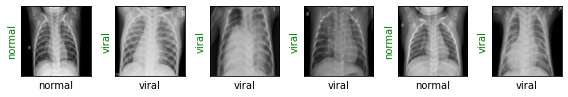

In [9]:
#now i will fetch a batch which is 6 images and 6 labels using the train dataloader

images, labels = next(iter(dl_train))
show_images(images, labels, labels)#for now we have labels as prediction

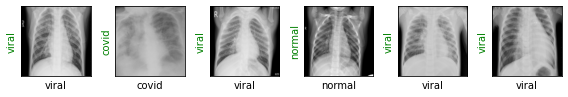

In [10]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

# Creating the Model

In [11]:
#we are interested in the end  last fully connected layer which has out_features=1000
#resnet 18 trained in image net data set which has 1000 classes and we only have 3
resnet18 = torchvision.models.resnet18(pretrained=True)
model = torchvision.models.resnet18(pretrained=True).cuda()
model=resnet18.eval()
print(resnet18)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
#change the last layer num of features 
#and define  loss-function & optimaizer

resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()

#we use adam we need to optimize all the parameters in the model and set the
#learning rate ,we can change it but this value worked fine(it shoul be small but can be increase)

optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [13]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    # dimension 0 corresponds to number of examples and dimension 1 coresponds to output
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

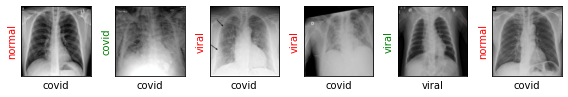

In [14]:
show_preds()

# Training the Model

In [15]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet18.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            #refresh our optimizer and set all gradian to 0
            optimizer.zero_grad()
            #pass the images to the model
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            #we have the loss now we want the gradiant step 
            #this is a back propagation
            loss.backward()
            #this will complete the gradian step which will update all param values
            optimizer.step()
            train_loss += loss.item()
            
            #every 20 steps we will eavaluate our model
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet18.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds()

                resnet18.train()
#we dont want to train the model for ever so we put a condition to satsify
                if accuracy >= 0.95:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

Starting training..
Starting epoch 1/1
Evaluating at step 0
Validation Loss: 1.2491, Accuracy: 0.3222


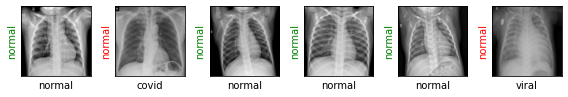

Evaluating at step 20
Validation Loss: 0.6071, Accuracy: 0.8778


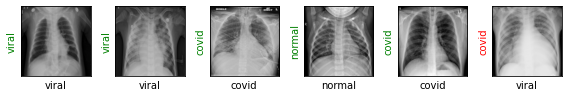

Evaluating at step 40
Validation Loss: 0.3796, Accuracy: 0.9000


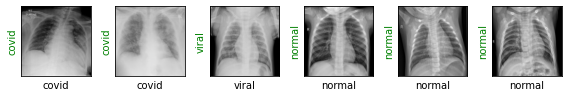

Evaluating at step 60
Validation Loss: 0.1765, Accuracy: 0.9444


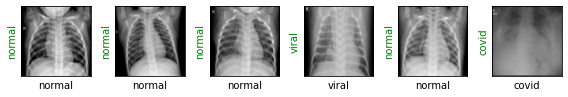

Evaluating at step 80
Validation Loss: 0.1510, Accuracy: 0.9444


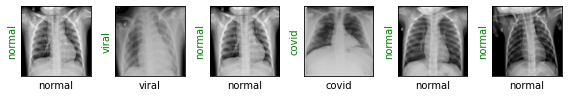

Evaluating at step 100
Validation Loss: 0.1961, Accuracy: 0.9444


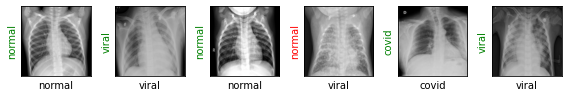

Evaluating at step 120
Validation Loss: 0.1951, Accuracy: 0.9333


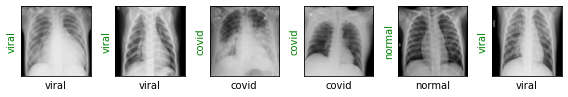

Evaluating at step 140
Validation Loss: 0.1447, Accuracy: 0.9333


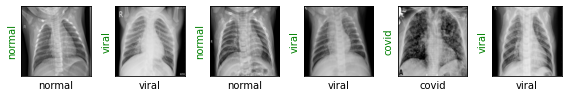

Evaluating at step 160
Validation Loss: 0.1647, Accuracy: 0.9444


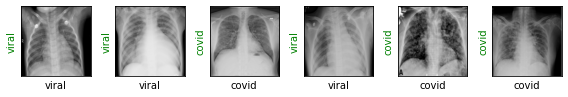

Evaluating at step 180
Validation Loss: 0.1396, Accuracy: 0.9667


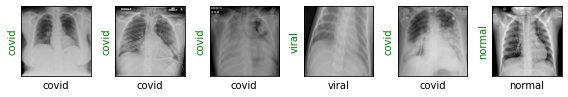

Performance condition satisfied, stopping..


In [16]:
#%%time

train(epochs=1)

# Final Results

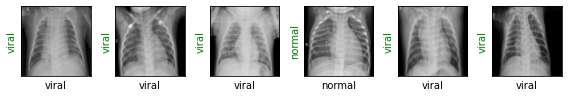

In [17]:
show_preds()

In [44]:
from PIL import Image
from matplotlib import cm


def torch_normalize(x):
    xmin = torch.min(x)
    xmax = torch.max(x)
    z = (x - xmin) / (xmax - xmin)
    return z


def np_normalize(x):
    xmin = np.min(x)
    xmax = np.max(x)
    z = (x - xmin) / (xmax - xmin)
    return z * 255.0


class CAM(object):

    def __init__(self, model):
        model_name = model.__class__.__name__
        print("hooking {}".format(model_name))
        assert model_name == "ResNet", "Model architecture not supported"

        model.layer4.register_forward_hook(self.__hook)
        self.conv_features = None
        self.model = model
        params = list(model.parameters())
        self.weights = params[-2]

    def __hook(self, _, inp, out):
        self.conv_features = out

    def generateCAM(self, idx, numpy=False):
        bz, n_kernels, h, w = self.conv_features.size()
        flat_features = self.conv_features.view(n_kernels, h * w)
        maps = self.weights.mm(flat_features)
        maps = maps.view(self.weights.size()[0], h, w)
        assert idx < maps.size()[0], "idx: [{}] but ony {} classes in output".format(idx, maps.size()[0])
        cam = (torch_normalize(maps[idx]) * 255).int()
        if numpy:
            return cam.cpu().detach().numpy()
        return cam

    def visualize(self, idx, img=None, f=50,alpha=0.9):
        cam = self.generateCAM(idx, numpy=True)
        cam[cam < f] = 0
        f = np.zeros((cam.shape[0], cam.shape[1], 3))
        f[:, :, 2] = alpha * cam
        cam = np.concatenate((np.expand_dims(cam, 2), f), 2).astype("uint8")
        for i in range(cam.shape[0]):
            for j in range(cam.shape[1]):
                cam[i, j, 0:3] = np.array(cm.jet(cam[i, j, 0]))[0:3] * 255
        if img:
            assert type(img) == Image.Image, "Please pass a PIL Image"
            assert img.size[0]==img.size[1], "x and y dimension must match"
            img = img.copy()
            FILTER = Image.BILINEAR
            overlay = Image.fromarray(cam).resize((int(img.size[0]), int(img.size[1])), FILTER)
            img.paste(overlay, (0, 0), overlay)
            return img
        else:
            overlay = Image.fromarray(cam).resize((100, 100))
            return overlay


In [50]:
model = torchvision.models.resnet18(pretrained=True)
#model=model.eval()
cam = CAM(model)

hooking ResNet


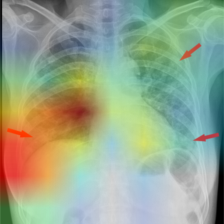

In [108]:
# Load an image of covid
img = Image.open("C:/Users/user/Desktop/xray/CovidDataset/val/Covid/special.jpeg").convert('RGB')


# Define Augmentation steps.
normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])

PIL_tops = torchvision.transforms.Compose([torchvision.transforms.Resize(224),torchvision.transforms.CenterCrop(224)])

tensor_tops = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), normalize])


cropped_img = PIL_tops(img)
trans_img = tensor_tops(cropped_img)




# Predict
out=model(trans_img.unsqueeze(0))
cam.visualize(228,cropped_img,alpha=0.8)

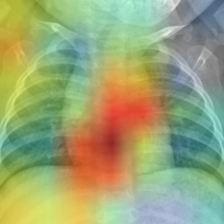

In [98]:
# Load an image of Normal
img = Image.open("C:/Users/user/Desktop/xray/CovidDataset/val/normal/NORMAL2-IM-1045-0001.jpeg").convert('RGB')



# Define Augmentation steps.
normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])

PIL_tops = torchvision.transforms.Compose([torchvision.transforms.Resize(224),torchvision.transforms.CenterCrop(224)])

tensor_tops = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), normalize])


cropped_img = PIL_tops(img)
trans_img = tensor_tops(cropped_img)




# Predict
out=model(trans_img.unsqueeze(0))
cam.visualize(228,cropped_img,alpha=0.8)

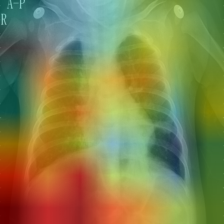

In [106]:
# Load an image of viral
img = Image.open("C:/Users/user/Desktop/xray/test viral/viral/Viral Pneumonia (89).png").convert('RGB')



# Define Augmentation steps.
normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])

PIL_tops = torchvision.transforms.Compose([torchvision.transforms.Resize(224),torchvision.transforms.CenterCrop(224)])

tensor_tops = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), normalize])


cropped_img = PIL_tops(img)
trans_img = tensor_tops(cropped_img)




# Predict
out=model(trans_img.unsqueeze(0))
cam.visualize(228,cropped_img,alpha=0.8)
